In [1]:
import numpy as np
import sys, os
path = os.getcwd()
path = os.path.join(path,"../src/")
sys.path.insert(0,path)


from all_processes import *
from physical_constants import *

from radiative_return import radiative_return_cross_section
from kinematics import radiative_return_fourvecs, invariant_mass

import vegas
from scipy import integrate

from copy import deepcopy
from multiprocessing import Pool
import pickle
from functools import partial
import argparse
import datetime
import tqdm

def generate_unit_vector(theta, phi):
    return np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])

def tree_level_cross_section(s, mV):
    eps = 1.
    alpha = 1./137.035999084
    mf = 0.51099895 * 1e-3
    prefactor = np.power(4.*np.pi*alpha*eps,2)
    sigma =  (np.sqrt(-4*np.power(mf,2) + s)*(2*np.power(mf,2)*np.power(np.power(mV,2) - s,2) - s*(np.power(mV,4) - np.power(mV,2)*s + np.power(s,2))) + \
     np.sqrt(s)*(-2*np.power(mf,2) + s)*(np.power(mV,4) + np.power(s,2))*np.arctanh(np.sqrt(1 - (4*np.power(mf,2))/s)))/ \
       (2.*np.pi*s*np.power(-4*np.power(mf,2) + s,2.5)*np.power(-np.power(mV,2) + s,1))
    return sigma*prefactor#*3.89379e+08 # 1/GeV^2 -> pb

# Test Integration of the Differential Cross Section and Compare to Tree-level

In [18]:
diff_xsection_options["RadRet"]

<function all_processes.dsigma_radiative_return_du(event_info, u)>

In [10]:
diff_xsec_func = diff_xsection_options["RadRet"] #dsigma_radiative_return_dx
#diff_xsec_func = lambda event_info, x: 1/np.power(1.-x,0.9) if 1.- x > 0. else 0.
event_info = {'E_inc': 4., 'mV': 0.05}
igrange = integration_range(event_info, "RadRet")
#integrand = vegas.Integrator(igrange)
integrand = vegas.Integrator([[igrange[0][0],igrange[0][1]]])
integrand(functools.partial(diff_xsec_func, event_info), nitn=10, neval=5000)
res = integrand(functools.partial(diff_xsec_func, event_info), nitn=10, neval=5000,alpha=0.1)

In [11]:
igrange

[[0.0, 0.9698309260745127]]

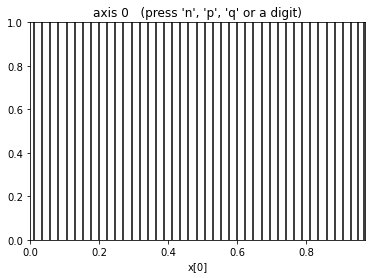

In [12]:
integrand.map.show_grid()


In [18]:
res[0].val

4.971150280241465

In [13]:
radiative_return_cross_section(2.*m_electron*(event_info['E_inc'] + m_electron), event_info['mV'])/3.89379e+08

5.01357072060178

In [11]:
integrate.quad(fff, igrange[0][0],igrange[0][1])

(4.971153094534614, 1.6577474874018784e-08)

In [15]:
2*integrate.quad(fff, np.sqrt(igrange[0][0]),igrange[0][1])[0]

31.64246563474835

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
x_list = np.linspace(igrange[0][0],igrange[0][1],1000)
plt.plot(x_list, [fff(x) for x in x_list])

NameError: name 'fff' is not defined

In [32]:
Einc_list = np.logspace(0,2,100)
rr_xsec_list = []
treelevel_xsec_list = []
for Einc in tqdm.tqdm(Einc_list):
    event_info = {'E_inc': Einc, 'mV': 0.1}
    
    igrange = integration_range(event_info, "RadRet")
    
    integrand = vegas.Integrator([[igrange[0][0],igrange[0][1]]])
    res = integrand(functools.partial(diff_xsec_func, event_info), nitn=10, neval=10000)
    if hasattr(res,'val'):
        rr_xsec_list.append(res.val)
    else:
        rr_xsec_list.append(res[0].val)
    
    s = 2.*m_electron*(Einc + m_electron)
    if s > event_info['mV']**2:
        treelevel_xsec_list.append(tree_level_cross_section(s, event_info['mV']))
    else:
        treelevel_xsec_list.append(0.)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


In [25]:
res.val

0.0

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

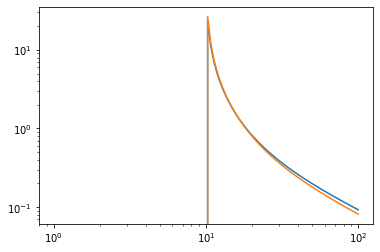

In [35]:

plt.plot(Einc_list, rr_xsec_list)
plt.plot(Einc_list, treelevel_xsec_list)
plt.xscale('log')
plt.yscale('log')

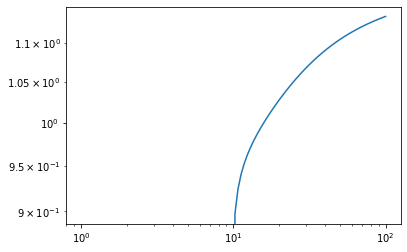

In [40]:

plt.plot(Einc_list, np.array(rr_xsec_list)/(1e-10+np.array(treelevel_xsec_list)))

plt.xscale('log')
plt.yscale('log')

In [43]:
Einc_list = np.logspace(0,2,100)
rr_xsec_list = []
treelevel_xsec_list = []
for Einc in tqdm.tqdm(Einc_list):
    event_info = {'E_inc': Einc, 'mV': 0.01}
    
    igrange = integration_range(event_info, "RadRet")
    
    integrand = vegas.Integrator([[igrange[0][0],igrange[0][1]]])
    res = integrand(functools.partial(diff_xsec_func, event_info), nitn=10, neval=10000)
    if hasattr(res,'val'):
        rr_xsec_list.append(res.val)
    else:
        rr_xsec_list.append(res[0].val)
    
    s = 2.*m_electron*(Einc + m_electron)
    if s > event_info['mV']**2:
        treelevel_xsec_list.append(tree_level_cross_section(s, event_info['mV']))
    else:
        treelevel_xsec_list.append(0.)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.23s/it]


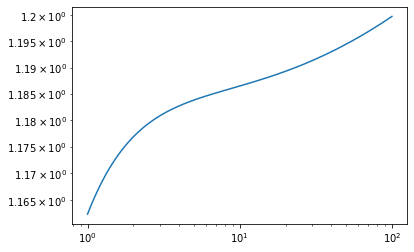

In [44]:

plt.plot(Einc_list, np.array(rr_xsec_list)/(1e-10+np.array(treelevel_xsec_list)))

plt.xscale('log')
plt.yscale('log')

# Test Sampling of the "luminosity" function

In [36]:
diff_xsec_func = diff_xsection_options["RadRet"] #dsigma_radiative_return_dx
#diff_xsec_func = lambda event_info, x: 1/np.power(1.-x,0.9) if 1.- x > 0. else 0.
event_info = {'E_inc': 5., 'mV': 0.05}
s = 2.*m_electron*(event_info['E_inc'] + m_electron)
igrange = integration_range(event_info, "RadRet")
#integrand = vegas.Integrator(igrange)
integrand = vegas.Integrator([[igrange[0][0],igrange[0][1]]])
integrand(functools.partial(diff_xsec_func, event_info), nitn=10, neval=10000)
res = integrand(functools.partial(diff_xsec_func, event_info), nitn=10, neval=10000)

In [67]:
fresh_integrand=vegas.Integrator(map=integrand.map, max_nhcube=1, neval=100000)
# these code bits are copied from all_processes.py
def get_points(distribution, npts):
    """If weights are too cumbersome, this function returns a properly-weighted sample from Dist"""
    ret = []
    MW = np.max(np.transpose(distribution)[-1])

    tochoosefrom = [pis for pis in range(len(distribution))]
    choicesgetter = rnd.choices(tochoosefrom, np.transpose(distribution)[-1], k=npts)
    for cg in choicesgetter:
        ret.append(distribution[cg][0:-1])

    return ret

integral, pts = 0.0, []
for x, wgt in fresh_integrand.random_batch():
    integral += wgt.dot(diff_xsec_func(event_info, x))

NSamp = 1
for kc in range(NSamp):
    for x, wgt in fresh_integrand.random():
        M0 = wgt*diff_xsec_func(event_info, x)
        #print(list(x), "\t", M0)
        pts.append(np.concatenate([list(x), M0]))

tr = np.array([integral, get_points(pts, 50000)], dtype=object)

In [62]:
diff_xsec_func

<function all_processes.dsigma_radiative_return_du(event_info, u)>

In [68]:
integral, res

(array([2.83848559]), RAvgArray([2.8384704(24)], dtype=object))

In [75]:
len(np.array(tr[1])[:,0])

50000

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'u')

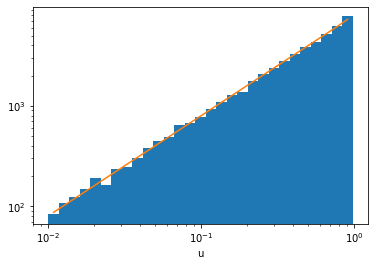

In [87]:
bins = np.logspace(-2,np.log10(igrange[0][1]),30)
bin_centers = 0.5*(bins[1:]+bins[:-1])
bin_diffs = bins[1:]-bins[:-1]
plt.hist(np.array(tr[1])[:,0], bins=bins)
plt.plot(bin_centers, \
         5e4*bin_diffs*np.array([dsigma_radiative_return_du(event_info, u)/integral[0] for u in bin_centers]))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('u')

Text(0.5, 0, 'u')

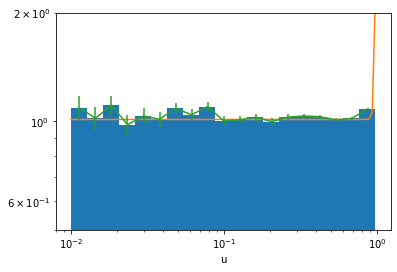

In [120]:
bins = np.logspace(-2,np.log10(igrange[0][1]),20)

a,b  = np.histogram(np.array(tr[1])[:,0], bins=bins)
a_dens, b_dens, _ = plt.hist(np.array(tr[1])[:,0], bins=bins,density=True)
u_list = np.logspace(-2,np.log10(igrange[0][1]),100)
plt.plot(u_list, [dsigma_radiative_return_du(event_info, u)/integral for u in u_list])
bin_centers = 0.5*(b_dens[1:]+b_dens[:-1])
plt.errorbar(bin_centers, a_dens, yerr=1./np.sqrt(a))


plt.ylim([0.5,2])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('u')

# Test Kinematics Generation

In [5]:
E_inc_test = 5.
mV_test = 0.05
event_info = {'E_inc': E_inc_test, 'mV': mV_test}
igrange = integration_range(event_info, "RadRet")
print("integration_range (u) = ", igrange)
u_test = np.random.uniform(igrange[0][0], igrange[0][1]) #(igrange[0][0]+igrange[0][1])/2
# The u variable is related to the actual energy fraction by u=(1-x)^beta/2, where beta = 
s = 2.*m_electron*(E_inc_test + m_electron)
print("sqrt(s)=", np.sqrt(s))
beta = (2.*alpha_em/np.pi) * (np.log(s/m_electron**2) - 1.)
print("beta = ", beta)
x1_test = 1. - np.power(u_test,2./beta)
print("x1_test = ", x1_test)
pe = np.array([E_inc_test, 0., 0., np.sqrt(E_inc_test**2 - m_electron**2)])


pV_lab = radiative_return_fourvecs(pe, mV_test, x1_test)
print(pV_lab)
print("sqrt(pV_lab^2) =", invariant_mass(pV_lab))

integration_range (u) =  [[0.0, 0.9755058184510245]]
sqrt(s)= 0.07148784330117815
beta =  0.04126177669734485
x1_test =  0.9978341056106063
x1, x2, x1*x2*s,  mV^2 =  0.9978341056106063 	 0.490249629922114 	 0.0025000000000000005 	 0.0025000000000000005
[4.98955073 0.         0.         4.9893002 ]
sqrt(pV_lab^2) = 0.049999999999977264


In [17]:


E_inc_test = 100.
mV_test = 0.2
event_info = {'E_inc': E_inc_test, 'mV': mV_test}
igrange = integration_range(event_info, "RadRet")
print("integration_range (u) = ", igrange)
u_test = np.random.uniform(igrange[0][0], igrange[0][1]) #(igrange[0][0]+igrange[0][1])/2
# The u variable is related to the actual energy fraction by u=(1-x)^beta/2, where beta = 
s = 2.*m_electron*(E_inc_test + m_electron)
print("sqrt(s)=", np.sqrt(s))
beta = (2.*alpha_em/np.pi) * (np.log(s/m_electron**2) - 1.)
print("beta = ", beta)
x1_test = 1. - np.power(u_test,2./beta)
print("x1_test = ", x1_test)

nhat = generate_unit_vector(0.1, 1.5)
pe = np.array([E_inc_test, 0., 0., 0])\
    +np.sqrt(E_inc_test**2 - m_electron**2)*np.array([0., nhat[0],nhat[1],nhat[2]])


print("Positron 4-momentum: ", pe)
pV_lab = radiative_return_fourvecs(pe, mV_test, x1_test)
print("Vector 4-momentum = ", pV_lab)
print("sqrt(pV_lab^2) =", invariant_mass(pV_lab))

integration_range (u) =  [[0.0, 0.9732588115306741]]
sqrt(s)= 0.3196878356144534
beta =  0.05517841616442101
x1_test =  0.9999999999948067
Positron 4-momentum:  [100.           0.70619365   9.95833326  99.50041653]
x1, x2, x1*x2*s,  mV^2 =  0.9999999999948067 	 0.39138823672408934 	 0.04000000000000001 	 0.04000000000000001
Vector 4-momentum =  [100.0003555    0.70619475   9.95834875  99.50057125]
sqrt(pV_lab^2) = 0.20000000000673027
